# This file is for creating the test accuracies of the varying models

In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from rfgap import RFGAP


# Get the data
sys.path.insert(0, '/yunity/arusty/PF-GAP')

static2024 = pd.read_csv('../data/static2024.csv')
static2023 = pd.read_csv('../data/static2023.csv')
static2022 = pd.read_csv('../data/static2022.csv')
static2025 = pd.read_csv('../data/static2025.csv')
time_series = np.array(pd.read_csv('../data/time_series.csv'))
labels = pd.read_csv('../data/labels.csv')
labels = np.array(labels).flatten()


from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test, static2023_train, static2023_test, static2024_train, static2024_test = train_test_split(time_series, 
labels, static2023, static2024, test_size=0.2, random_state=42)


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import pandas as pd


def determine_static(fold):
    if fold < 2:
        static_train = static2022
        static_test = static2023
    elif fold < 4:
        static_train = static2023
        static_test = static2024
    else:
        static_train = static2024
        static_test = static2025

    return np.array(static_train), np.array(static_test)

def get_cross_validation_results(get_predictions_method):
    # Set up cross-validation
    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    results = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(time_series, labels)):
        print(f"Fold {fold + 1}/{skf.n_splits}: {len(train_idx)} train samples, {len(test_idx)} test samples")
        # Split data
        X_train, X_test = time_series[train_idx], time_series[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        
        static_train, static_test = determine_static(fold)

        y_pred, prox_train, prox_test = get_predictions_method(X_train, y_train, X_test, static_train[train_idx], static_test[test_idx])
        
        # RF metrics
        rf_f1 = f1_score(y_test, y_pred, average='weighted')
        rf_recall = recall_score(y_test, y_pred, average='weighted')
        rf_precision = precision_score(y_test, y_pred, average='weighted')
        rf_acc = accuracy_score(y_test, y_pred)

        #KNN metrics
        if prox_train is None or prox_test is None:
            acc = None
            f1 = None
            precision = None
            recall = None
        else:
            knn = KNeighborsClassifier(n_neighbors=4, metric='precomputed')
            knn.fit(1 - prox_train, y_train)
            y_pred = knn.predict(1- prox_test)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            
        results.append({
            'fold': fold,
            'train_idx': train_idx,
            'test_idx': test_idx,
            'rf_f1': rf_f1,
            'rf_recall': rf_recall,
            'rf_precision': rf_precision,
            'rf_accuracy': rf_acc,
            'knn_accuracy': acc,
            'knn_f1': f1,
            'knn_precision': precision,
            'knn_recall': recall
        })

    # Convert results to DataFrame
    return pd.DataFrame(results)

import matplotlib.pyplot as plt

def plot_cv_results(results_df):
    """
    Plots cross-validation metrics for each fold.
    Args:
        results_df (pd.DataFrame): DataFrame returned by get_cross_validation_results
    """
    metrics = [
        ("rf_accuracy", "RF Accuracy"),
        ("rf_f1", "RF F1"),
        ("rf_precision", "RF Precision"),
        ("rf_recall", "RF Recall"),
        ("knn_accuracy", "KNN Accuracy"),
        ("knn_f1", "KNN F1"),
        ("knn_precision", "KNN Precision"),
        ("knn_recall", "KNN Recall"),
    ]
    plt.figure(figsize=(12, 6))
    for metric, label in metrics:
        if metric in results_df.columns:
            plt.plot(results_df["fold"], results_df[metric], marker='o', label=label)
    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.title("Cross-Validation Metrics by Fold")
    plt.legend()
    plt.grid(True)
    plt.show()




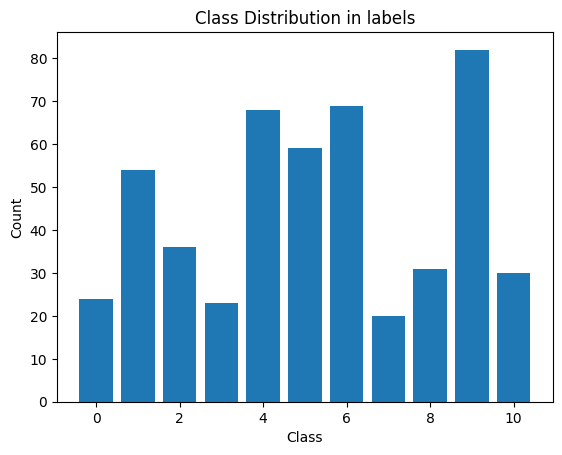

In [2]:
# Class distribuation
import matplotlib.pyplot as plt

unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in labels')
plt.show()

In [3]:
TIME = "daily"

# RF - Rocket

In [4]:
from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket
rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512)
rocket.fit(X_train, y_train, static2023_train, weights = None)
pred = rocket.predict(X_test, static2024_test)

score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")


Accuracy: 0.52


In [5]:
rocket.rocket.transform(X_train).shape, len(X_train), len(X_test), #len(static2023_train), len(static2024_test)

((396, 4032), 396, 100)

In [6]:
rocket.get_proximities().shape

(396, 396)

In [7]:
rocket.get_test_proximities(X_test, static2024_test).shape

(100, 396)

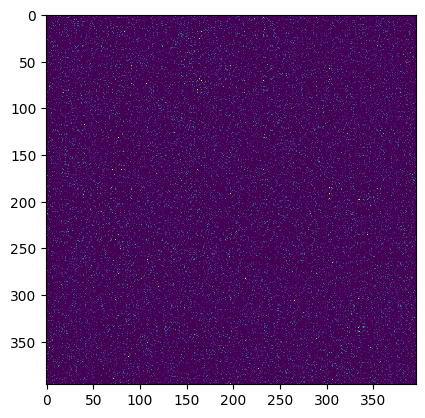

In [8]:
plt.imshow(np.clip(rocket.get_proximities().toarray(), 0,0.1), cmap='viridis', interpolation='nearest')

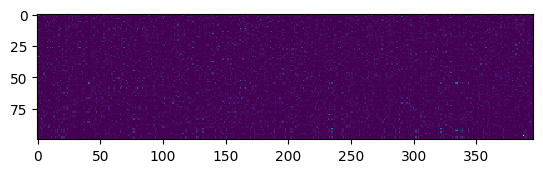

In [9]:
plt.imshow(rocket.get_test_proximities(X_test, static2024_test).toarray(), cmap='viridis', interpolation='nearest')

In [10]:
def get_rocket_pred(X_train, y_train, X_test, static_train, static_test):
    rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512, prox_method = "original")
    
    rocket.fit(X_train, y_train, static_train, weights = None)
    return rocket.predict(X_test, static_test), rocket.get_proximities().toarray(), rocket.get_test_proximities(X_test, static_test).toarray()



In [ ]:
rocket_fold = get_cross_validation_results(get_rocket_pred)
rocket_fold.to_csv(f'../data/results/original/rocket_fold_{TIME}.csv', index=False)
rocket_fold 

Fold 1/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples


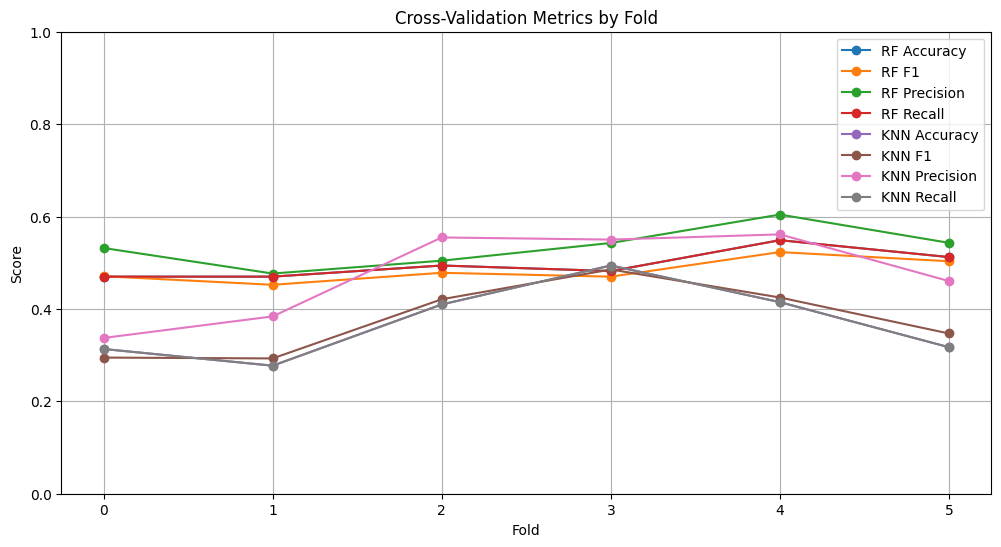

In [ ]:
plot_cv_results(rocket_fold)

# RDST TRIALS

In [ ]:
from RDST.rdst import RDST_GAP

rdst = RDST_GAP(save_transformed_data = True)
rdst.fit(X_train, y_train, static = static2023_train)
pred = rdst.predict(X_test, static = static2024_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

Accuracy: 0.60


In [ ]:
rdst.get_proximities()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 85839 stored elements and shape (396, 396)>

In [ ]:
rdst.extend_prox(X_test, static2024_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 32494 stored elements and shape (100, 396)>

In [ ]:
def get_rdst_pred(X_train, y_train, X_test, static_train, static_test):
    rdst = RDST_GAP(save_transformed_data = True, prox_method = "original")
    rdst.fit(X_train, y_train, static = static_train)
    return rdst.predict(X_test, static = static_test), rdst.get_proximities().toarray(), rdst.extend_prox(X_test, static_test).toarray()
    

rdst_fold = get_cross_validation_results(get_rdst_pred)
rdst_fold.to_csv(f'../data/results/original/rdst_fold_{TIME}.csv', index=False)

rdst_fold

Fold 1/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


fold                                          train_idx  \
0     0  [0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...   
1     1  [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
2     2  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...   
3     3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...   
4     4  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...   
5     5  [0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...   

                                            test_idx     rf_f1  rf_recall  \
0  [1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...  0.585562   0.590361   
1  [0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...  0.583607   0.614458   
2  [7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...  0.644129   0.662651   
3  [9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...  0.562984   0.590361   
4  [8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...  0.612463   0.634146   
5  [3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...  0.588237   0.597561   

   rf_precision  rf_accuracy  knn_accuracy    knn_f1  knn_precision  \
0      0.694769     0.590361      0.469880  0.469335       0.538481   
1      0.625760     0.614458      0.481928  0.494985       0.586344   
2      0.663727     0.662651      0.530120  0.525561       0.602051   
3      0.608032     0.590361      0.493976  0.489788       0.556938   
4      0.641007     0.634146      0.536585  0.559032       0.643342   
5      0.632650     0.597561      0.475610  0.486739       0.539810   

   knn_recall  
0    0.469880  
1    0.481928  
2    0.530120  
3    0.493976  
4    0.536585  
5    0.475610

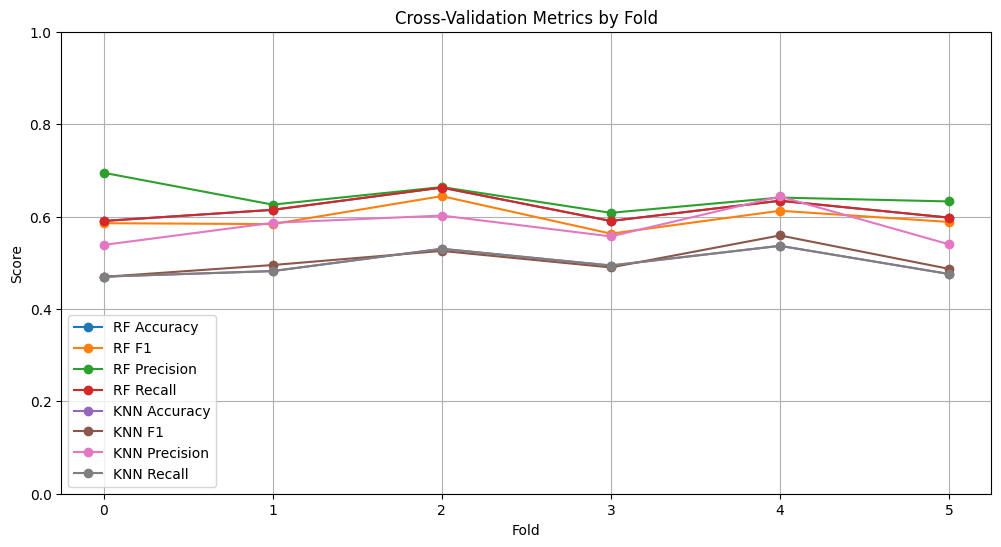

In [ ]:
plot_cv_results(rdst_fold)

# QUANT TRIALS

In [ ]:
from QGAP.qgap import QGAP
qgap= QGAP(matrix_type="dense")

qgap.fit(X_train,y_train, static = static2023_train)
pred = qgap.predict(X_test, static = static2024_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

Accuracy: 0.62


In [ ]:
type(qgap.get_proximities())


numpy.ndarray

In [ ]:
type(qgap.prox_extend(X_test, static2024_test))

numpy.matrix

In [ ]:
def get_qgap_pred(X_train, y_train, X_test, static_train, static_test):
    qgap = QGAP(matrix_type="dense", prox_method = "original")
    qgap.fit(X_train, y_train, static = static_train)
    return qgap.predict(X_test, static = static_test), qgap.get_proximities(), np.array(qgap.prox_extend(X_test, static_test))
    

qgap_fold = get_cross_validation_results(get_qgap_pred)
qgap_fold.to_csv(f'../data/results/original/qgap_fold_{TIME}.csv', index=False)
qgap_fold

Fold 1/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


fold                                          train_idx  \
0     0  [0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...   
1     1  [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
2     2  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...   
3     3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...   
4     4  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...   
5     5  [0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...   

                                            test_idx     rf_f1  rf_recall  \
0  [1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...  0.554503   0.566265   
1  [0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...  0.582194   0.614458   
2  [7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...  0.635566   0.650602   
3  [9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...  0.574603   0.590361   
4  [8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...  0.592442   0.609756   
5  [3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...  0.574725   0.585366   

   rf_precision  rf_accuracy  knn_accuracy    knn_f1  knn_precision  \
0      0.626779     0.566265      0.566265  0.580274       0.634317   
1      0.594919     0.614458      0.518072  0.522892       0.557487   
2      0.644190     0.650602      0.506024  0.497260       0.505325   
3      0.602326     0.590361      0.445783  0.442107       0.490584   
4      0.620821     0.609756      0.560976  0.554014       0.578123   
5      0.600232     0.585366      0.536585  0.555565       0.624227   

   knn_recall  
0    0.566265  
1    0.518072  
2    0.506024  
3    0.445783  
4    0.560976  
5    0.536585

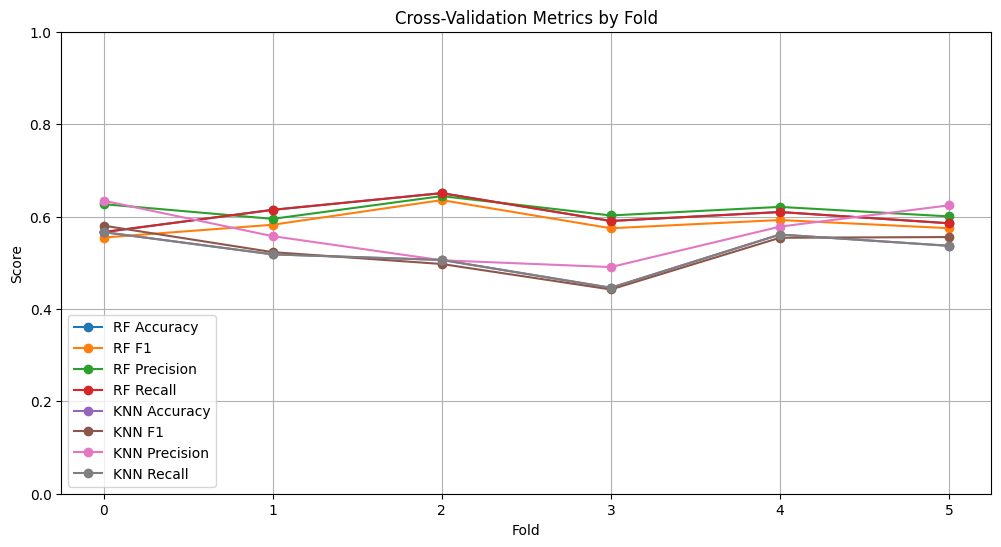

In [ ]:
plot_cv_results(qgap_fold)

# RedCommets

In [ ]:
from Redcomets.Redcomets import REDCOMETS
rc = REDCOMETS(variant = 3, static = static2023_train, debug_mode=False)
rc.fit(X_train, y_train)


REDCOMETS(static=      PE Ratio   PB Ratio   PS Ratio       ROE       ROA  Debt/Equity  \
56   36.875910   2.493953   1.209477  0.187583  0.036626      101.467   
227  35.726387 -14.232141  11.074953 -0.483475  0.074086       74.277   
391  15.647273   2.192378   4.616868  0.152219  0.119516       10.012   
329  51.739147  19.432201  11.619553  0.262673  0.110974       72.513   
220  21.952726   7.276124   2.045558 -1.402486 -0.227690      297.468   
..         ...        ...        ...       ...       ...          ...   
106  24.688597   4.9...
220          1.600      -0.297664              -0.145              0.0785   
..             ...            ...                 ...                 ...   
106          0.867       0.221288               0.094             -0.0610   
270          3.174       0.366868               0.163              0.0500   
348          1.318       0.211297              -0.058             -0.1120   
435          5.258       0.371597               0.111              0.0670   
102          1.703       0.128768               0.035              0.2260   

       Market Cap  
56   1.426579e+10  
227  5.256173e+10  
391  6.556876e+10  
329  4.667961e+11  
220  8.459406e+09  
..            ...  
106  2.239379e+11  
270  1.388217e+10  
348  3.371016e+10  
435  1.475250e+11  
102  2.466268e+10  

[396 rows x 11 columns])

In [ ]:
pred = rc.predict(X_test, static = static2024_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

Accuracy: 0.76


In [ ]:
def get_redcomets_pred(X_train, y_train, X_test, static_train, static_test):
    rc = REDCOMETS(static = static_train, variant=3, prox_method = "original")
    rc.fit(X_train, y_train)
    return rc.predict(X_test, static = static_test), None, None
    

rc = get_cross_validation_results(get_redcomets_pred)
rc.to_csv(f'../data/results/original/redcomets_fold_{TIME}.csv', index=False)
rc


Fold 1/6: 413 train samples, 83 test samples
Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples
Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6/6: 414 train samples, 82 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


fold                                          train_idx  \
0     0  [0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...   
1     1  [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
2     2  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...   
3     3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...   
4     4  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...   
5     5  [0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...   

                                            test_idx     rf_f1  rf_recall  \
0  [1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...  0.771392   0.771084   
1  [0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...  0.765125   0.783133   
2  [7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...  0.784581   0.795181   
3  [9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...  0.718488   0.734940   
4  [8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...  0.728393   0.743902   
5  [3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...  0.686377   0.682927   

   rf_precision  rf_accuracy knn_accuracy knn_f1 knn_precision knn_recall  
0      0.824673     0.771084         None   None          None       None  
1      0.800383     0.783133         None   None          None       None  
2      0.810499     0.795181         None   None          None       None  
3      0.731070     0.734940         None   None          None       None  
4      0.802927     0.743902         None   None          None       None  
5      0.773236     0.682927         None   None          None       None

# PF GAP

In [ ]:
X_train

array([[-0.03484876,  0.01566482,  0.00153123, ...,  0.02262156,
         0.00268764,  0.04164949],
       [ 0.00958062, -0.02667377,  0.00250313, ...,  0.02957135,
         0.02240791,  0.01857355],
       [-0.01639289, -0.03518049,  0.0055787 , ...,  0.04274342,
         0.00403079,  0.02026033],
       ...,
       [ 0.02485801, -0.03577665, -0.00026312, ...,  0.01467947,
         0.00762799,  0.03700319],
       [ 0.00104946, -0.02085956, -0.00032121, ...,  0.00789777,
         0.03672663,  0.06559324],
       [ 0.00108144,  0.00707157,  0.00165771, ...,  0.00688384,
        -0.01656236, -0.01879955]])

In [ ]:
sys.path.insert(0, '/yunity/arusty/PF-GAP/PFGAP')

from PFGAP.PyPFGAP import PyPFGAP
pf = PyPFGAP()
pf.fit(X_train, y_train)
pred = pf.predict(X_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

reading file [train]:Error executing PFGAP.jar: Command '['java', '-jar', '-Xmx1g', '/yunity/arusty/PF-GAP/PFGAP/Application/PFGAP.jar', '-train=/yunity/arusty/data/train', '-test=/yunity/arusty/data/test', '-out=output', '-repeats=1', '-trees=18', '-r=5', '-on_tree=true', '-shuffle=false', '-export=1', '-verbosity=1', '-csv_has_header=false', '-target_column=first', '-getprox=true', '-savemodel=true', '-modelname=PF']' returned non-zero exit status 255.



Fatal Error:: For input string: "1.0"

java.lang.NumberFormatException: For input string: "1.0"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:67)
	at java.base/java.lang.Integer.parseInt(Integer.java:665)
	at java.base/java.lang.Integer.parseInt(Integer.java:781)
	at core.CSVReader.readCSVToListDataset(CSVReader.java:88)
	at core.ExperimentRunner.run(ExperimentRunner.java:37)
	at application.PFApplication.main(PFApplication.java:113)


FileNotFoundError: [Errno 2] No such file or directory: 'ForestProximities.txt'

# Fresh Prince

In [4]:
from FreshPrince.FreshPrince import FreshPRINCE_GAP
fp = FreshPRINCE_GAP()
fp.fit(X_train, y_train, static = static2023_train)
pred = fp.predict(X_test, static = static2024_test)
score = (pred == y_test).mean()
print(f"Accuracy: {score:.2f}")

ModuleNotFoundError: FreshPRINCE_GAP requires package 'tsfresh' to be present in the python environment, but 'tsfresh' was not found. 'tsfresh' is a soft dependency and not included in the base aeon installation. Please run: `pip install tsfresh` to install the tsfresh package. To install all soft dependencies, run: `pip install aeon[all_extras]`

In [ ]:
type(fp.get_proximities()), type(np.array(fp.get_extend(X_test, static2024_test))), type(pred)

(scipy.sparse._csr.csr_matrix, numpy.ndarray, numpy.ndarray)

In [ ]:
np.array(fp.get_extend(X_test, static2024_test).todense())

array([[0.00055556, 0.00083333, 0.00285083, ..., 0.        , 0.00017241,
        0.00291722],
       [0.002     , 0.00364286, 0.00191744, ..., 0.00038462, 0.00104841,
        0.00125   ],
       [0.00071429, 0.        , 0.00188034, ..., 0.        , 0.        ,
        0.0187717 ],
       ...,
       [0.        , 0.000625  , 0.        , ..., 0.        , 0.00090022,
        0.        ],
       [0.0024359 , 0.00125   , 0.        , ..., 0.        , 0.01281494,
        0.        ],
       [0.001     , 0.        , 0.        , ..., 0.00337037, 0.00790689,
        0.        ]])

In [5]:
from FreshPrince.FreshPrince import FreshPRINCE_GAP

def get_fresh_pred(X_train, y_train, X_test, static_train, static_test):
    fp = FreshPRINCE_GAP(prox_method = "original")
    fp.fit(X_train, y_train, static = static_train)
    return fp.predict(X_test, static = static_test), np.array(fp.get_proximities().todense()), np.array(fp.get_extend(X_test, static_test).todense())
    
fresh_fold = get_cross_validation_results(get_fresh_pred)
fresh_fold.to_csv(f'../data/results/original/fresh_fold_{TIME}.csv', index=False)

fresh_fold

Fold 1/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4/6: 413 train samples, 83 test samples


/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/6: 414 train samples, 82 test samples
Fold 6/6: 414 train samples, 82 test samples


fold                                          train_idx  \
0     0  [0, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...   
1     1  [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
2     2  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15...   
3     3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...   
4     4  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...   
5     5  [0, 1, 2, 4, 5, 7, 8, 9, 11, 13, 16, 17, 18, 2...   

                                            test_idx     rf_f1  rf_recall  \
0  [1, 2, 5, 21, 23, 28, 31, 36, 63, 75, 85, 98, ...  0.702997   0.722892   
1  [0, 4, 22, 29, 30, 39, 42, 48, 50, 53, 55, 65,...  0.716270   0.746988   
2  [7, 13, 18, 20, 35, 44, 60, 61, 70, 78, 91, 96...  0.727290   0.746988   
3  [9, 11, 17, 25, 27, 34, 37, 38, 40, 46, 51, 57...  0.706493   0.734940   
4  [8, 16, 24, 26, 33, 47, 52, 54, 56, 71, 73, 74...  0.769742   0.780488   
5  [3, 6, 10, 12, 14, 15, 19, 32, 41, 43, 45, 49,...  0.724135   0.731707   

   rf_precision  rf_accuracy  knn_accuracy    knn_f1  knn_precision  \
0      0.726443     0.722892      0.710843  0.692360       0.705767   
1      0.710584     0.746988      0.746988  0.728512       0.736500   
2      0.734509     0.746988      0.710843  0.688553       0.693874   
3      0.733267     0.734940      0.686747  0.657122       0.668203   
4      0.820887     0.780488      0.743902  0.733646       0.788618   
5      0.771856     0.731707      0.731707  0.722789       0.758246   

   knn_recall  
0    0.710843  
1    0.746988  
2    0.710843  
3    0.686747  
4    0.743902  
5    0.731707

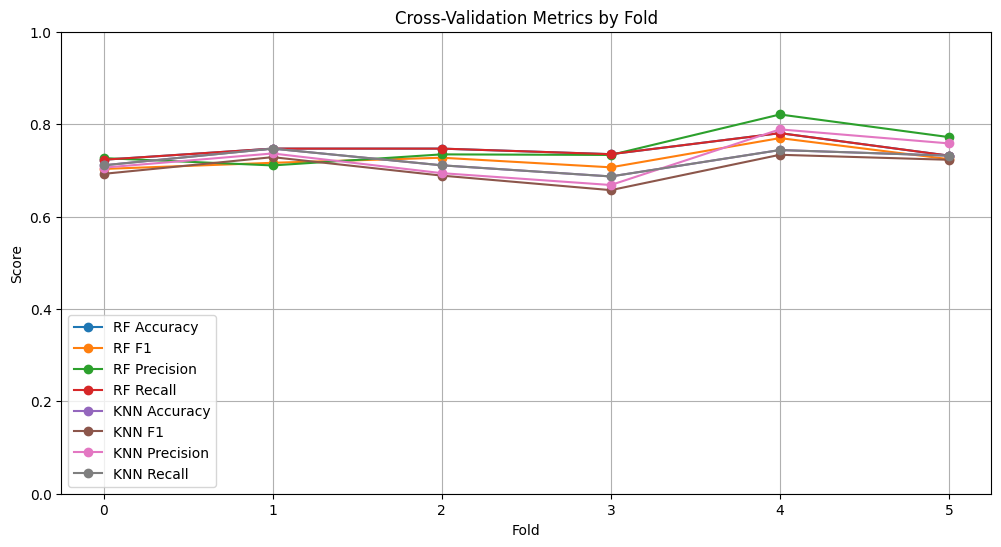

In [8]:
plot_cv_results(fresh_fold)

# Distance Measures
These are created just by applying the distances directly to the time series. 

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import seaborn as sns

# Function to plot heatmap sorted by class
def heatmap_sorted(dist_matrix, labels, title="Proximity Matrix Heatmap (Sorted by Class)"):
    sort_idx = np.argsort(labels)
    sorted_matrix = dist_matrix[sort_idx][:, sort_idx]
    sorted_labels = labels[sort_idx]
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_matrix, cmap='viridis', square=True, cbar=True)
    plt.title(title)
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Sample Index (sorted)")

    # Find indices where the class changes
    class_change_indices = np.where(np.diff(sorted_labels) != 0)[0] + 1
    for idx in class_change_indices:
        plt.axvline(idx, color='white', linestyle='--', linewidth=1)
        plt.axhline(idx, color='white', linestyle='--', linewidth=1)

    plt.show()

def evaluate_knn_on_distance_matrix(distance_matrix, labels, n_neighbors=1):
    """
    Perform 6-fold cross-validation using KNN with a precomputed distance matrix.
    Args:
        distance_matrix (np.ndarray): Square distance matrix (n_samples x n_samples)
        labels (np.ndarray): Array of labels (n_samples,)
        n_neighbors (int): Number of neighbors for KNN (default 1)
    Returns:
        pd.DataFrame: DataFrame with accuracy, F1, precision, and recall for each fold
    """
    heatmap_sorted(distance_matrix, labels)

    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    results = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(distance_matrix, labels)):
        # Extract the relevant submatrices for precomputed distances
        train_dist = distance_matrix[np.ix_(train_idx, train_idx)]
        test_dist = distance_matrix[np.ix_(test_idx, train_idx)]
        y_train, y_test = labels[train_idx], labels[test_idx]

        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='precomputed')
        knn.fit(train_dist, y_train)
        y_pred = knn.predict(test_dist)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        results.append({
            'fold': fold,
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })
    return pd.DataFrame(results)


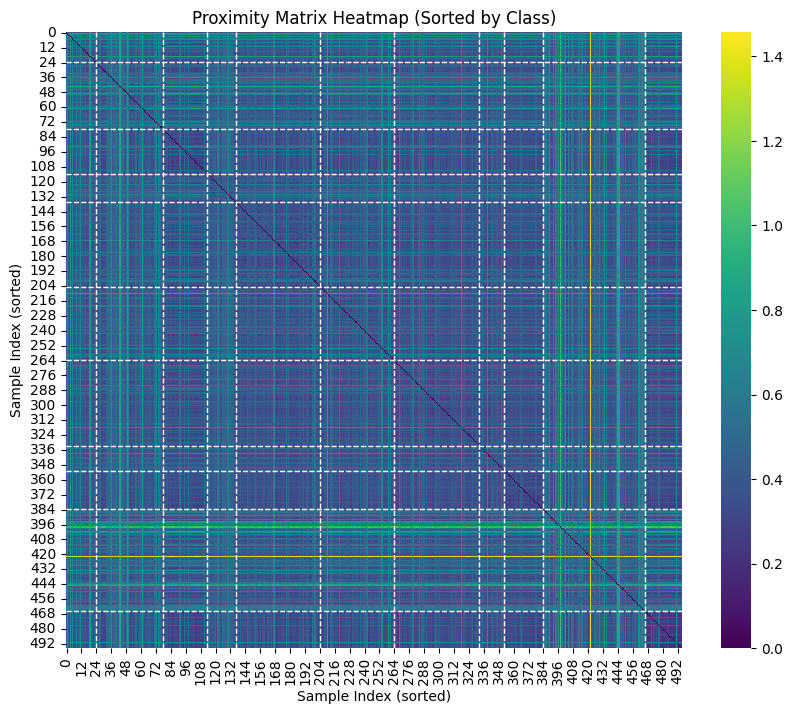

fold  accuracy        f1  precision    recall
0     0  0.674699  0.667987   0.673134  0.674699
1     1  0.686747  0.675776   0.749636  0.686747
2     2  0.734940  0.730772   0.755795  0.734940
3     3  0.698795  0.680527   0.685197  0.698795
4     4  0.768293  0.758545   0.775304  0.768293
5     5  0.670732  0.666544   0.698763  0.670732

In [9]:
dtw = np.load('../data/prox_files_daily/dtw_matrix.npy')
dtw_results = evaluate_knn_on_distance_matrix(dtw, labels, n_neighbors=1)
dtw_results.to_csv('../data/results/distances/dtw_knn_results.csv', index=False)
dtw_results

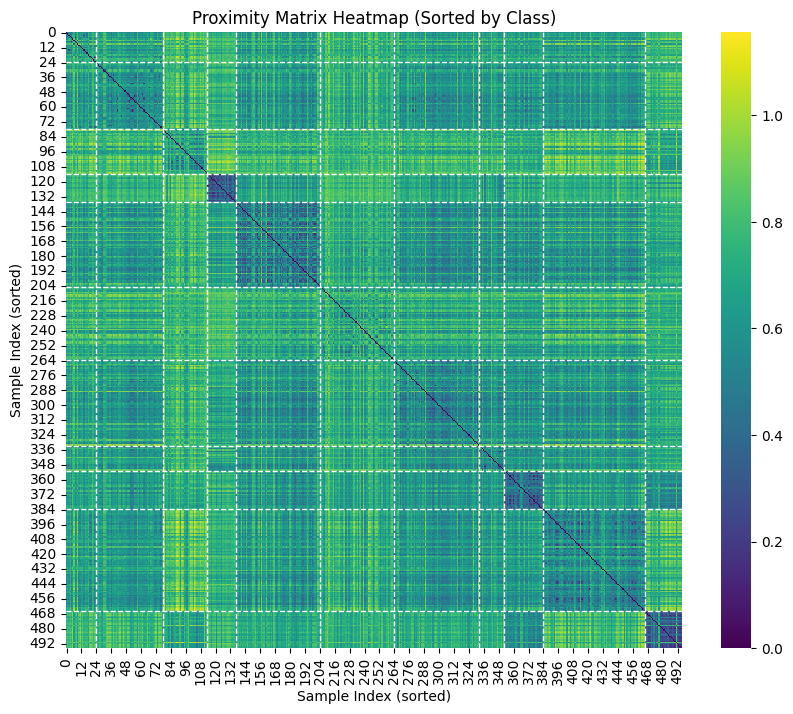

fold  accuracy        f1  precision    recall
0     0  0.891566  0.890087   0.898482  0.891566
1     1  0.903614  0.899153   0.908306  0.903614
2     2  0.819277  0.816757   0.829030  0.819277
3     3  0.843373  0.845279   0.863558  0.843373
4     4  0.878049  0.876971   0.889141  0.878049
5     5  0.878049  0.866844   0.900898  0.878049

In [10]:
cosine = np.load('../data/prox_files_daily/cosine_matrix.npy')
cosine_results = evaluate_knn_on_distance_matrix(cosine, labels, n_neighbors=1)
cosine_results.to_csv('../data/results/distances/cosine_knn_results.csv', index=False)
cosine_results

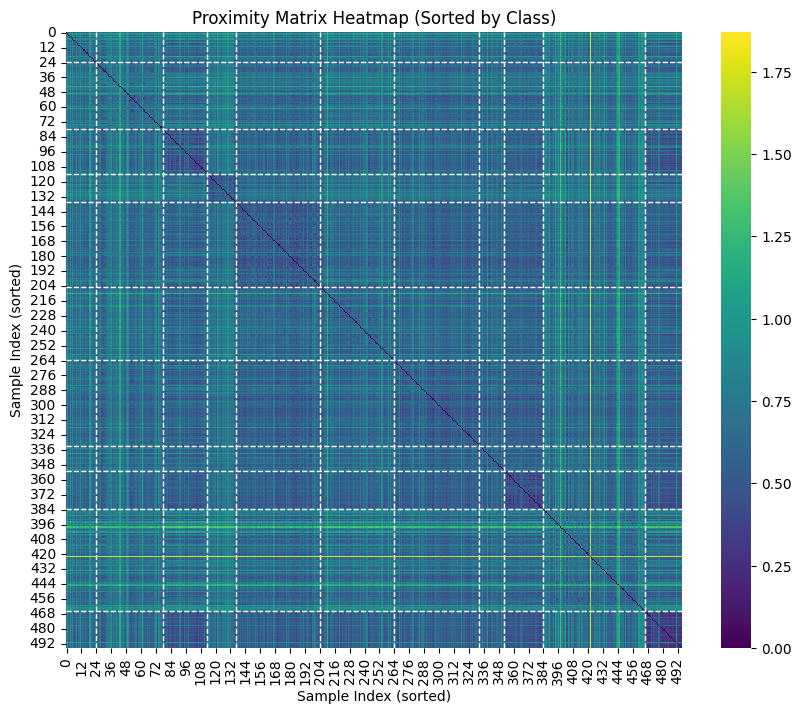

fold  accuracy        f1  precision    recall
0     0  0.819277  0.817526   0.856673  0.819277
1     1  0.831325  0.831362   0.855816  0.831325
2     2  0.783133  0.781871   0.811277  0.783133
3     3  0.783133  0.780335   0.842239  0.783133
4     4  0.829268  0.827283   0.856498  0.829268
5     5  0.780488  0.780945   0.827392  0.780488

In [12]:
euclid = np.load('../data/prox_files_daily/euclidean_matrix.npy')
euclid_results = evaluate_knn_on_distance_matrix(euclid, labels, n_neighbors=1)
euclid_results.to_csv('../data/results/distances/euclid_knn_results.csv', index=False)
euclid_results

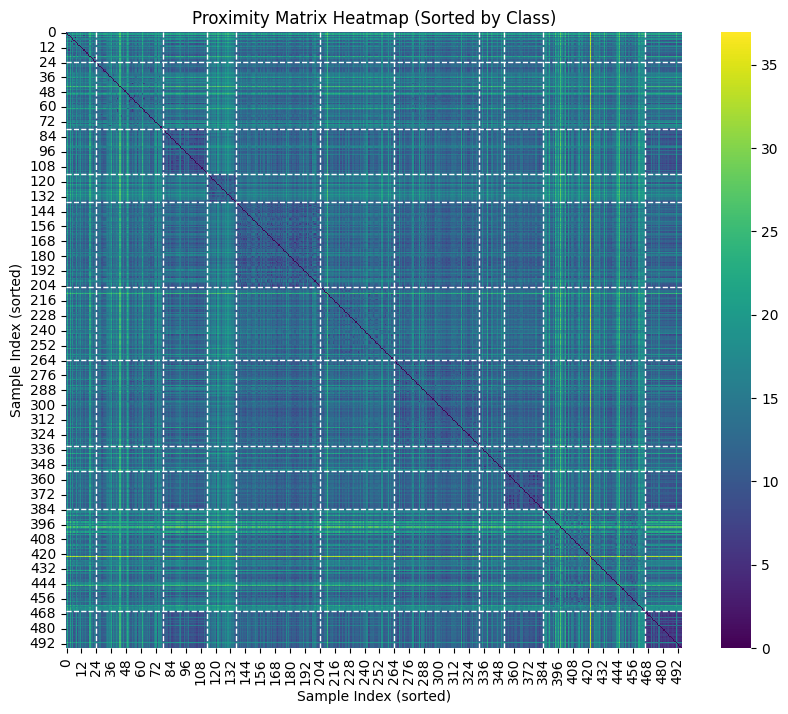

fold  accuracy        f1  precision    recall
0     0  0.795181  0.787746   0.824415  0.795181
1     1  0.879518  0.875864   0.896730  0.879518
2     2  0.855422  0.853362   0.872614  0.855422
3     3  0.783133  0.784282   0.835858  0.783133
4     4  0.865854  0.863287   0.898134  0.865854
5     5  0.804878  0.799974   0.837486  0.804878

In [13]:
manhattan = np.load('../data/prox_files_daily/manhattan_matrix.npy')
manhattan_results = evaluate_knn_on_distance_matrix(manhattan, labels, n_neighbors=1)
manhattan_results.to_csv('../data/results/distances/manhattan_knn_results.csv', index=False)
manhattan_results

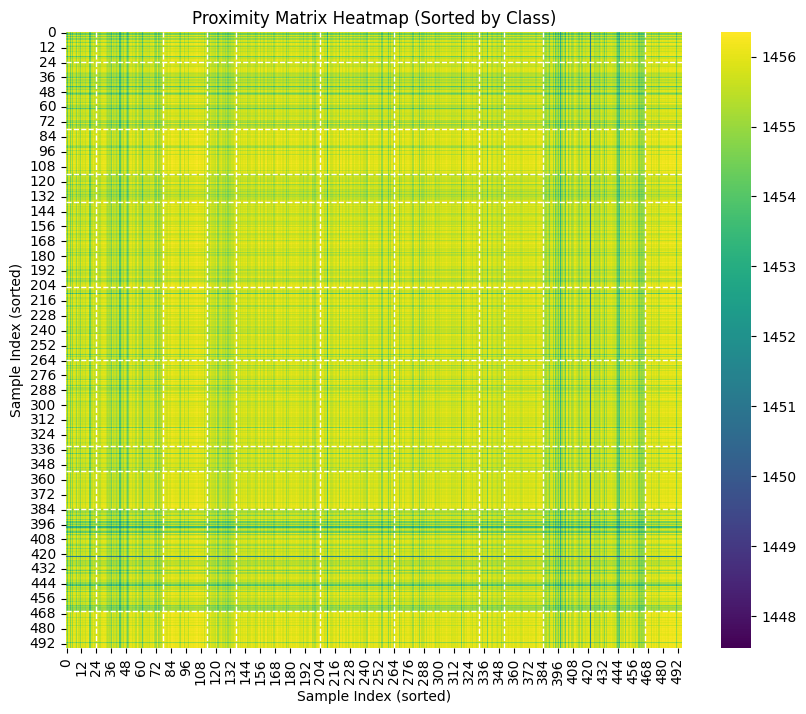

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

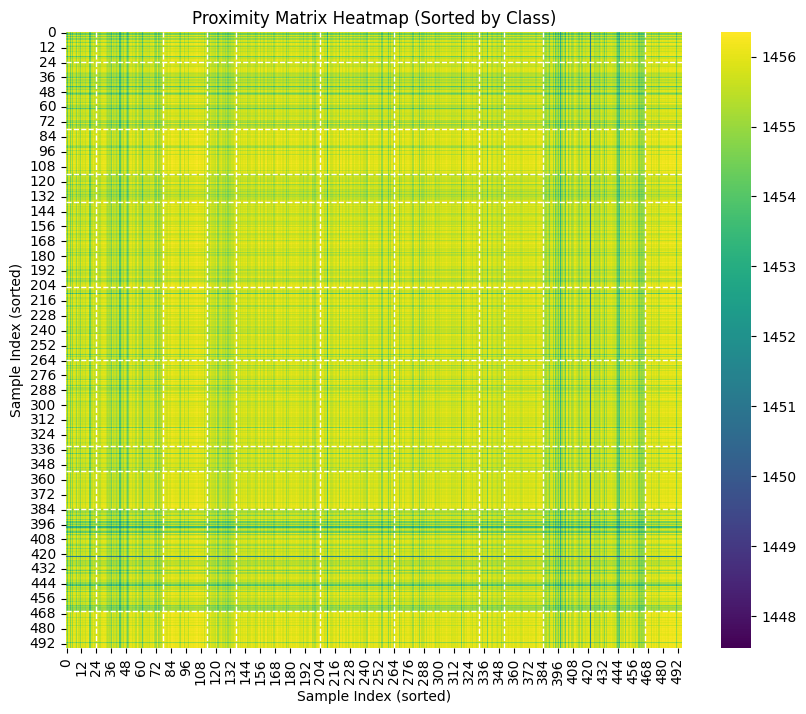

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

fold  accuracy        f1  precision    recall
0     0  0.156627  0.042420   0.024532  0.156627
1     1  0.156627  0.042420   0.024532  0.156627
2     2  0.168675  0.048690   0.028451  0.168675
3     3  0.168675  0.048690   0.028451  0.168675
4     4  0.170732  0.049797   0.029149  0.170732
5     5  0.170732  0.049797   0.029149  0.170732

In [14]:
soft_dtw = np.load('../data/prox_files_daily/soft_dtw_matrix.npy')
evaluate_knn_on_distance_matrix(1 - soft_dtw, labels, n_neighbors=1)
soft_dtw_results = evaluate_knn_on_distance_matrix(1 - soft_dtw, labels, n_neighbors=1)
soft_dtw_results.to_csv('../data/results/distances/soft_dtw_knn_results.csv', index=False)
soft_dtw_results

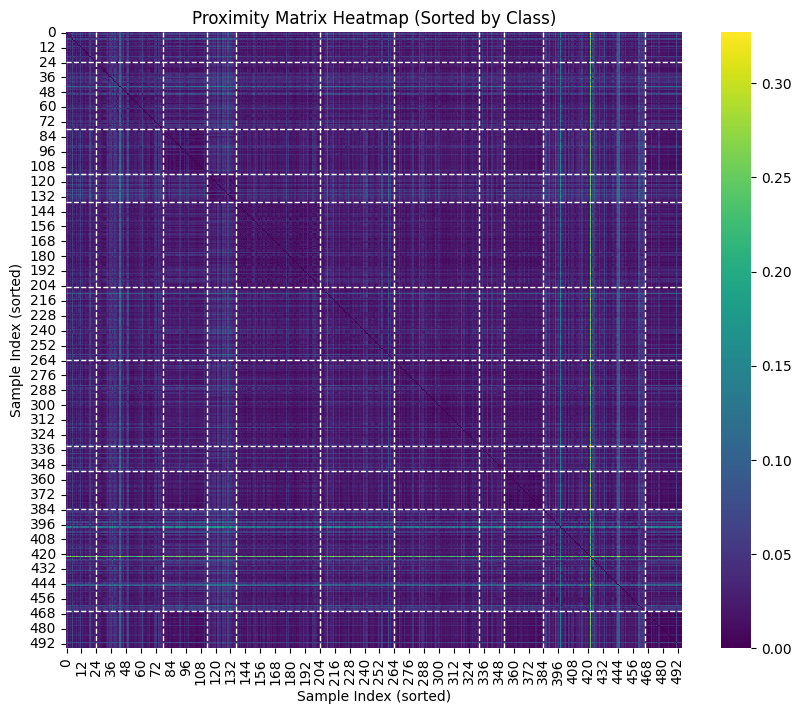

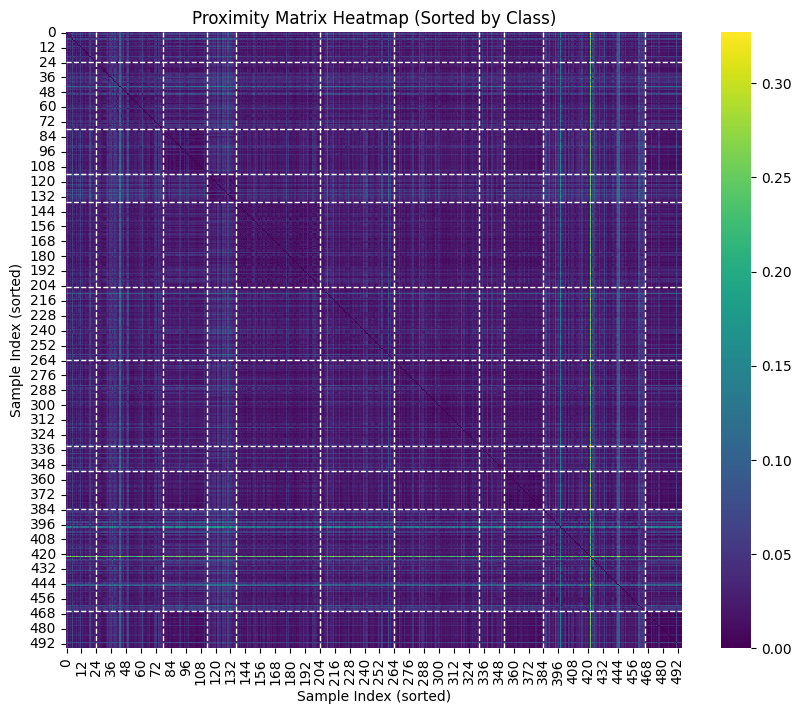

fold  accuracy        f1  precision    recall
0     0  0.626506  0.616498   0.667762  0.626506
1     1  0.722892  0.714464   0.749646  0.722892
2     2  0.674699  0.661829   0.673177  0.674699
3     3  0.650602  0.642409   0.653831  0.650602
4     4  0.756098  0.755010   0.790454  0.756098
5     5  0.682927  0.683641   0.727523  0.682927

In [15]:
soft_dtw_normalized = np.load('../data/prox_files_daily/soft_dtw_normalized_matrix.npy')
evaluate_knn_on_distance_matrix(soft_dtw_normalized, labels, n_neighbors=1)
soft_dtw_normalized_results = evaluate_knn_on_distance_matrix(soft_dtw_normalized, labels, n_neighbors=1)
soft_dtw_normalized_results.to_csv('../data/results/distances/soft_dtw_normalized_knn_results.csv', index=False)
soft_dtw_normalized_results

## The Proximities from our methods
Something is off here? Maybe it is the labels

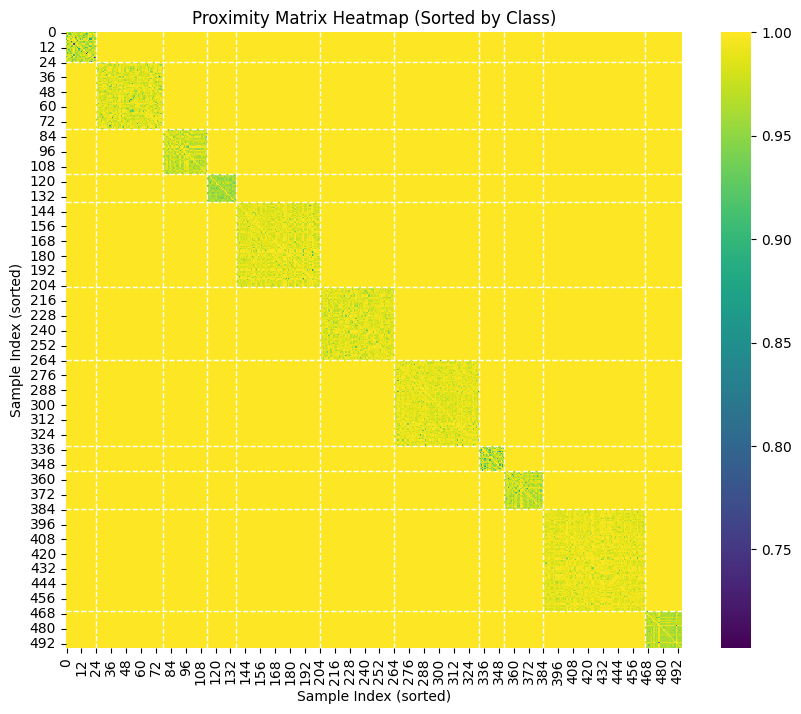

fold  accuracy   f1  precision  recall
0     0       1.0  1.0        1.0     1.0
1     1       1.0  1.0        1.0     1.0
2     2       1.0  1.0        1.0     1.0
3     3       1.0  1.0        1.0     1.0
4     4       1.0  1.0        1.0     1.0
5     5       1.0  1.0        1.0     1.0

In [ ]:
fresh = np.load('../data/prox_files_monthly/fresh_prince_prox.npy')
evaluate_knn_on_distance_matrix(1- fresh, labels, n_neighbors=5)

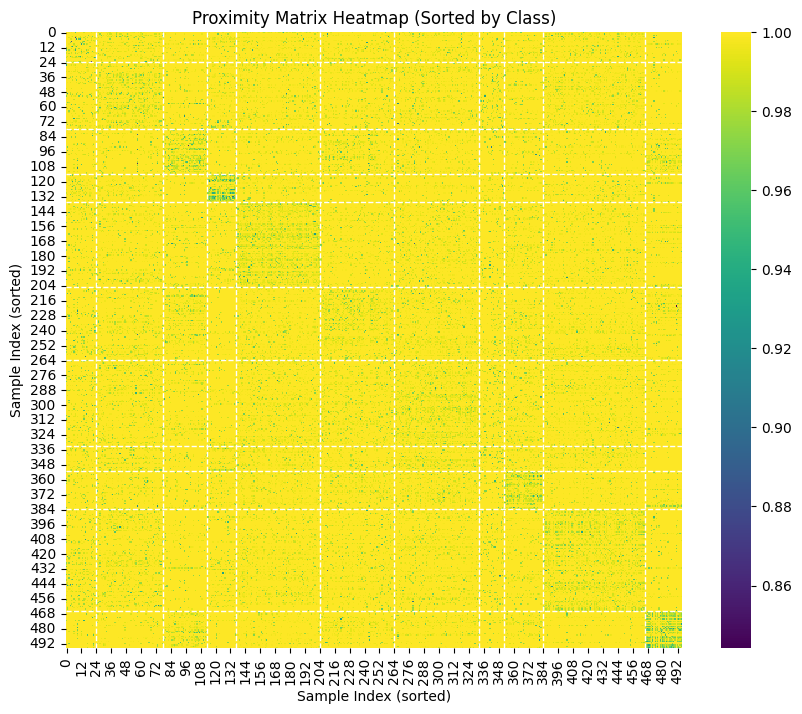

fold  accuracy        f1  precision    recall
0     0  0.228916  0.212505   0.234177  0.228916
1     1  0.265060  0.291897   0.372752  0.265060
2     2  0.373494  0.369506   0.423795  0.373494
3     3  0.289157  0.294364   0.333764  0.289157
4     4  0.292683  0.284260   0.292881  0.292683
5     5  0.341463  0.343349   0.396138  0.341463

In [ ]:
rocket = np.load('../data/prox_files_monthly/rocket_prox.npy')
evaluate_knn_on_distance_matrix(1- rocket, labels, n_neighbors=1)

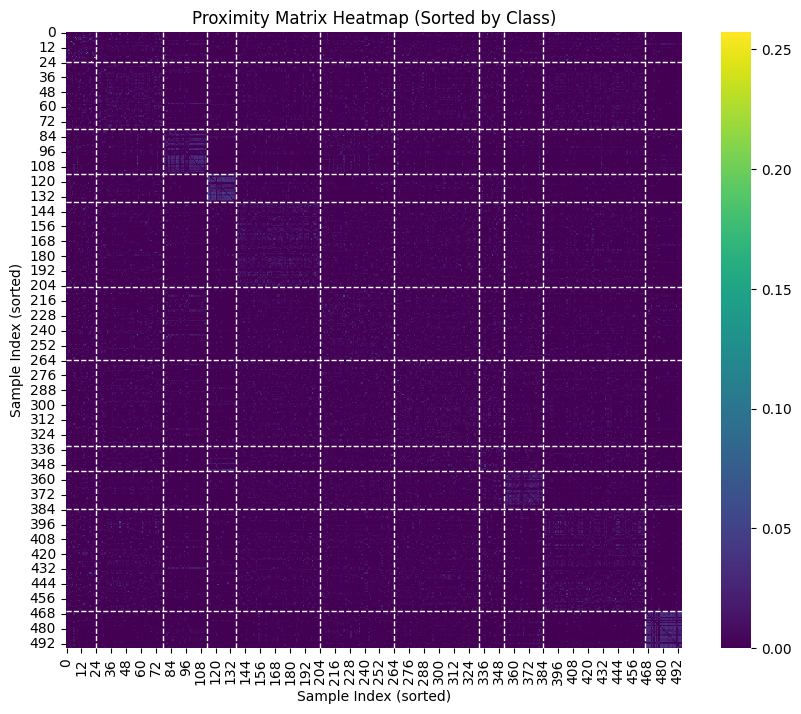

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

fold  accuracy        f1  precision    recall
0     0  0.060241  0.069551   0.083534  0.060241
1     1  0.132530  0.140990   0.160752  0.132530
2     2  0.060241  0.056901   0.060749  0.060241
3     3  0.036145  0.040836   0.048594  0.036145
4     4  0.060976  0.058012   0.062331  0.060976
5     5  0.073171  0.072493   0.078920  0.073171

In [ ]:
quant = np.load('../data/prox_files/quant_prox.npy')
evaluate_knn_on_distance_matrix(quant, labels, n_neighbors=5)

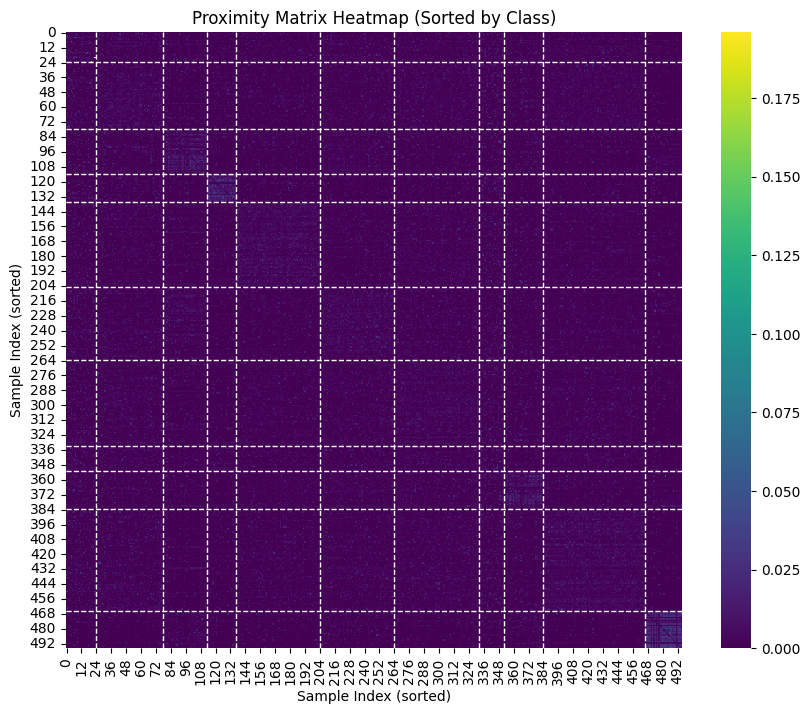

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


fold  accuracy        f1  precision    recall
0     0  0.060241  0.052655   0.049351  0.060241
1     1  0.072289  0.061579   0.056777  0.072289
2     2  0.036145  0.027005   0.022892  0.036145
3     3  0.012048  0.008032   0.006024  0.012048
4     4  0.036585  0.023854   0.017791  0.036585
5     5  0.073171  0.075554   0.083618  0.073171

In [ ]:
rdst = np.load('../data/prox_files/rdst_prox.npy')
evaluate_knn_on_distance_matrix(rdst, labels, n_neighbors=5)